Fetching these images!

In [1]:
import os
import cv2
from tqdm import tqdm

def create_dataset(root_dir):
    dataset = []
    masks = []
    labels = []
    
    for label in os.listdir(root_dir):
        label_dir = os.path.join(root_dir, label)
        if os.path.isdir(label_dir):
            images_folder = os.path.join(label_dir, 'images')
            masks_folder = os.path.join(label_dir, 'masks')
            if os.path.isdir(images_folder) and os.path.isdir(masks_folder):
                for image_file in tqdm(os.listdir(images_folder), desc=label):
                    image_path = os.path.join(images_folder, image_file)
                    mask_path = os.path.join(masks_folder, image_file)  # Assuming same name for images and masks
                    if os.path.isfile(mask_path):
                        # Read image and mask using OpenCV
                        img = cv2.imread(image_path)
                        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                        if img is not None and mask is not None:
                            # You can process the image and mask here if needed
                            img = cv2.resize(img, (224, 224))  # Adjust the size as needed
                            mask = cv2.resize(mask, (224, 224))  # Adjust the size as needed
                            dataset.append(img)
                            masks.append(mask)
                            labels.append(label)
    
    return dataset, masks, labels

root_folder = 'E:\\Projects\\Unfinished\\COVID Project\\COVID-19_Radiography'
dataset, masks, labels = create_dataset(root_folder)

print("Number of images:", len(dataset))
print("Number of masks:", len(masks))
print("Number of labels:", len(labels))


Viral Pneumonia: 100%|██████████| 1345/1345 [00:41<00:00, 32.78it/s]

Number of images: 21165
Number of masks: 21165
Number of labels: 21165


Displaying a couple of images

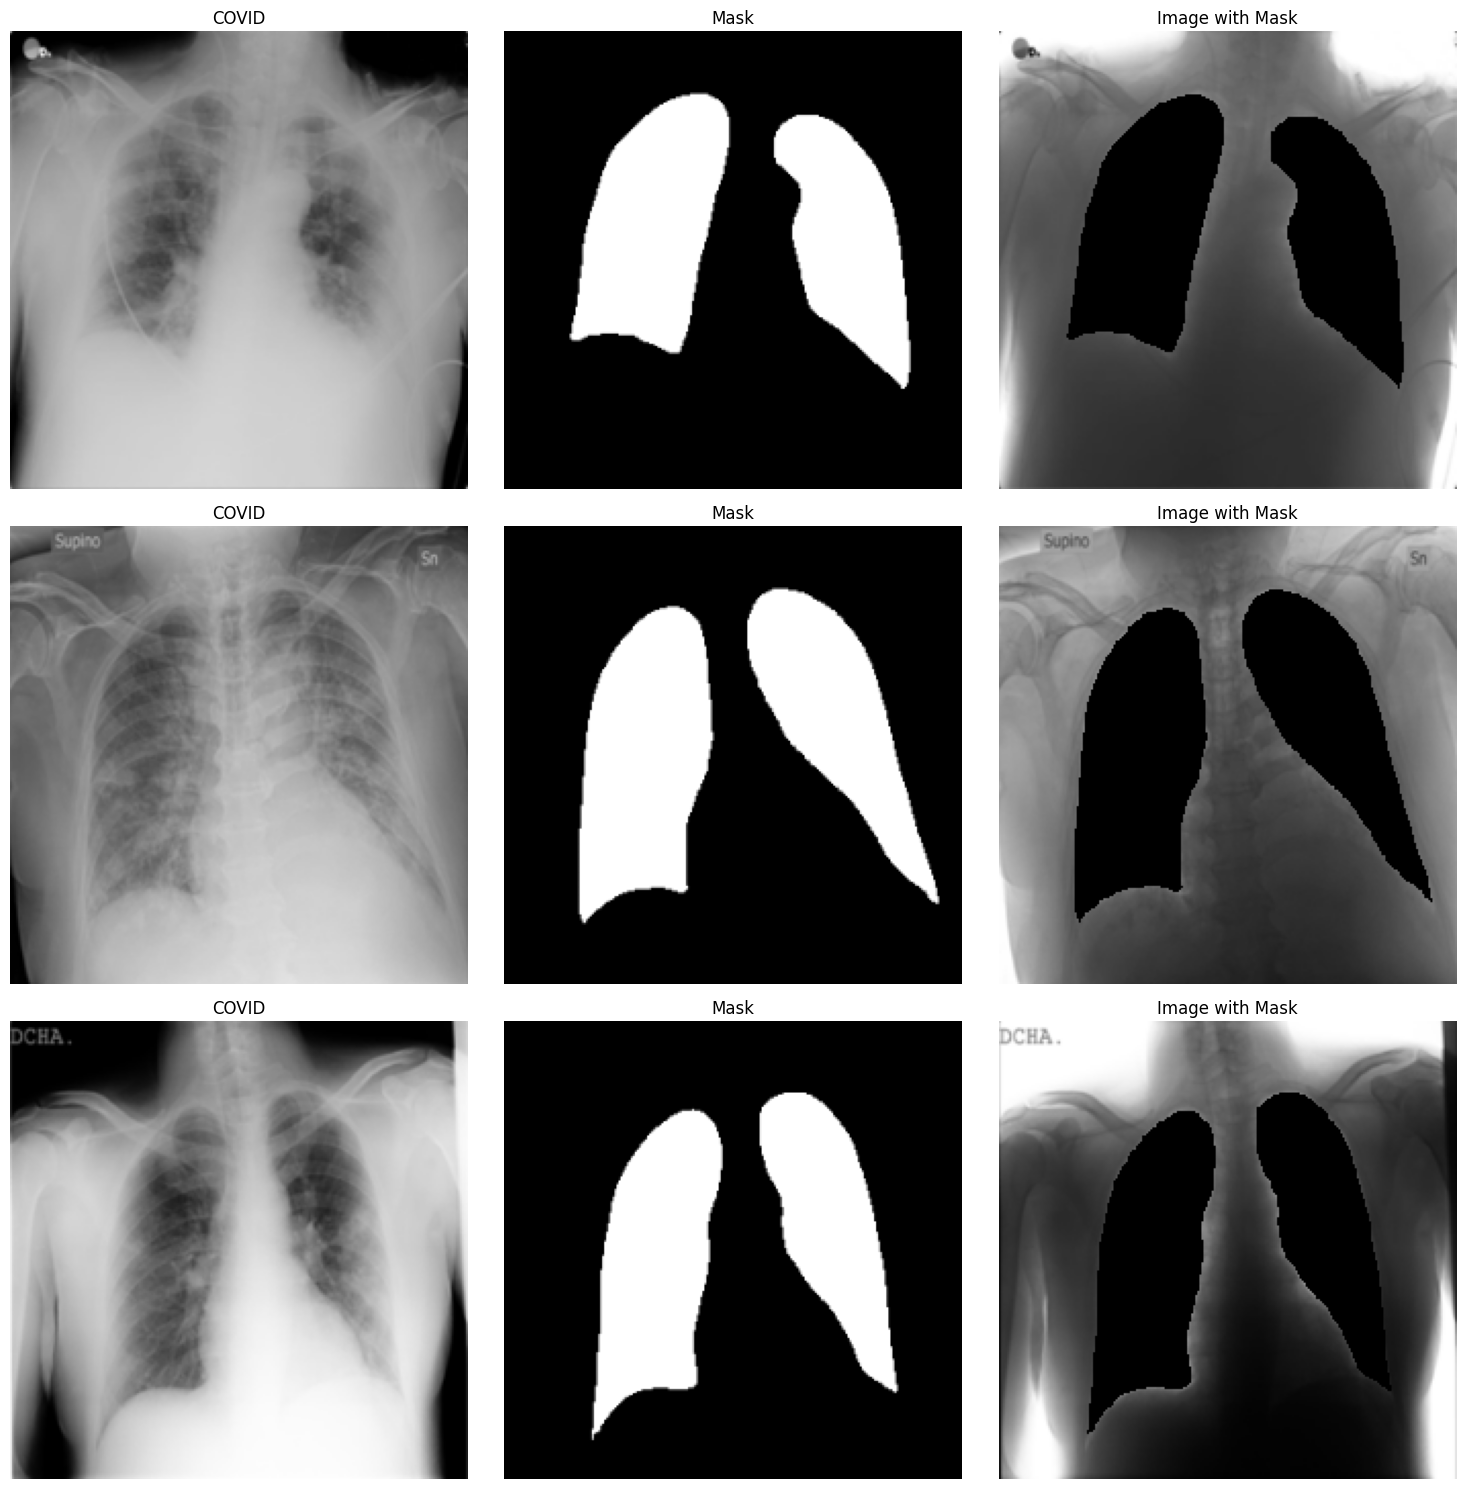

In [2]:
import matplotlib.pyplot as plt
def display_images_with_masks_side_by_side(images, masks, labels):
    num_samples = len(images)
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
    for i in range(num_samples):
        axes[i, 0].imshow(images[i])
        axes[i, 0].set_title(labels[i])
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(masks[i], cmap='gray')
        axes[i, 1].set_title('Mask')
        axes[i, 1].axis('off')
        
        masked_image = cv2.bitwise_not(images[i], mask=cv2.bitwise_not(masks[i]))
        axes[i, 2].imshow(masked_image)
        axes[i, 2].set_title('Image with Mask')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()


num_samples_to_display = 3
display_images_with_masks_side_by_side(dataset[:num_samples_to_display], masks[:num_samples_to_display], labels[:num_samples_to_display])

Splitting between training and testing and moving to CUDA

Importing the ViT

In [3]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)



In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import ViTFeatureExtractor

class CustomDataset(Dataset):
    def __init__(self, images, numeric_labels, feature_extractor=None, transform=None):
        self.images = images
        self.labels = numeric_labels
        self.feature_extractor = feature_extractor
        self.transform = transform  # Keep torchvision transforms for comparison or additional processing
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        # Apply torchvision transforms if any
        if self.transform:
            image = self.transform(image)
        
        # Use the feature extractor from Hugging Face for Vision Transformer models
        if self.feature_extractor:
            image = self.feature_extractor(images=image, return_tensors="pt").pixel_values[0]
        
        return {"pixel_values": image, "labels": torch.tensor(label, dtype=torch.long)}

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

custom_dataset = CustomDataset(dataset, labels)
data_loader = DataLoader(custom_dataset, batch_size=32, shuffle=True)


In [5]:
from transformers import ViTForImageClassification, ViTConfig

# Load pre-trained Vision Transformer
model_name = 'google/vit-base-patch16-224-in21k'  
config = ViTConfig.from_pretrained(model_name, num_labels=4)  # Binary classification: COVID vs. Non-COVID
model = ViTForImageClassification.from_pretrained(model_name, config=config)
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

custom_dataset = CustomDataset(dataset, labels, feature_extractor=feature_extractor)




Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\Ahmad\AppData\Local\Pro

In [6]:
from torch.utils.data.dataset import random_split

val_size = int(len(custom_dataset) * 0.2)  # 20% for validation
train_size = len(custom_dataset) - val_size  # The rest for training

train_dataset, val_dataset = random_split(custom_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [7]:
import torch
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss

loss_fn = CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=5e-5)


In [8]:
# Check if CUDA is available and set the device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device} device')

model.to(device)


Using cuda device


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [9]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    acc = accuracy_score(labels, predictions)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }


In [10]:
from transformers import Trainer, TrainingArguments


training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    save_strategy="epoch",
    evaluation_strategy="epoch",  
    load_best_model_at_end=True,  
    metric_for_best_model="accuracy",  
)


trainer = Trainer(
    model=model,                         
    args=training_args,                 
    train_dataset=train_dataset,       
    eval_dataset=val_dataset,        
    compute_metrics=compute_metrics,  
)

trainer.train()


c:\Users\Ahmad\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/1590 [00:00<?, ?it/s]

{'loss': 1.3797, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.02}
{'loss': 1.3673, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.04}
{'loss': 1.342, 'learning_rate': 3e-06, 'epoch': 0.06}
{'loss': 1.3032, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.08}
{'loss': 1.2472, 'learning_rate': 5e-06, 'epoch': 0.09}
{'loss': 1.2006, 'learning_rate': 6e-06, 'epoch': 0.11}
{'loss': 1.1144, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.13}
{'loss': 1.0341, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.15}
{'loss': 0.9378, 'learning_rate': 9e-06, 'epoch': 0.17}
{'loss': 0.9042, 'learning_rate': 1e-05, 'epoch': 0.19}
{'loss': 0.9074, 'learning_rate': 1.1000000000000001e-05, 'epoch': 0.21}
{'loss': 0.7928, 'learning_rate': 1.2e-05, 'epoch': 0.23}
{'loss': 0.7805, 'learning_rate': 1.3000000000000001e-05, 'epoch': 0.25}
{'loss': 0.7568, 'learning_rate': 1.4000000000000001e-05, 'epoch': 0.26}
{'loss': 0.7149, 'learning_rate': 1.5e-05, 'epoch': 0.28}
{'loss': 0.6612, 'learni

  0%|          | 0/67 [00:00<?, ?it/s]

{'eval_loss': 0.2786526083946228, 'eval_accuracy': 0.9133002598629814, 'eval_f1': 0.9121404998694056, 'eval_precision': 0.9222297316674737, 'eval_recall': 0.9133002598629814, 'eval_runtime': 600.9367, 'eval_samples_per_second': 7.044, 'eval_steps_per_second': 0.111, 'epoch': 1.0}
{'loss': 0.2375, 'learning_rate': 4.81651376146789e-05, 'epoch': 1.02}
{'loss': 0.2172, 'learning_rate': 4.7706422018348626e-05, 'epoch': 1.04}
{'loss': 0.2784, 'learning_rate': 4.724770642201835e-05, 'epoch': 1.06}
{'loss': 0.1941, 'learning_rate': 4.678899082568808e-05, 'epoch': 1.08}
{'loss': 0.2553, 'learning_rate': 4.6330275229357804e-05, 'epoch': 1.09}
{'loss': 0.2311, 'learning_rate': 4.587155963302753e-05, 'epoch': 1.11}
{'loss': 0.1889, 'learning_rate': 4.541284403669725e-05, 'epoch': 1.13}
{'loss': 0.1938, 'learning_rate': 4.4954128440366975e-05, 'epoch': 1.15}
{'loss': 0.1869, 'learning_rate': 4.44954128440367e-05, 'epoch': 1.17}
{'loss': 0.3204, 'learning_rate': 4.403669724770643e-05, 'epoch': 1.19

  0%|          | 0/67 [00:00<?, ?it/s]

{'eval_loss': 0.16043274104595184, 'eval_accuracy': 0.9518072289156626, 'eval_f1': 0.9518074307642626, 'eval_precision': 0.9519632328747337, 'eval_recall': 0.9518072289156626, 'eval_runtime': 1052.927, 'eval_samples_per_second': 4.02, 'eval_steps_per_second': 0.064, 'epoch': 2.0}
{'loss': 0.1466, 'learning_rate': 2.3853211009174313e-05, 'epoch': 2.02}
{'loss': 0.0869, 'learning_rate': 2.339449541284404e-05, 'epoch': 2.04}
{'loss': 0.0774, 'learning_rate': 2.2935779816513765e-05, 'epoch': 2.06}
{'loss': 0.0821, 'learning_rate': 2.2477064220183487e-05, 'epoch': 2.08}
{'loss': 0.0846, 'learning_rate': 2.2018348623853213e-05, 'epoch': 2.09}
{'loss': 0.1272, 'learning_rate': 2.155963302752294e-05, 'epoch': 2.11}
{'loss': 0.1392, 'learning_rate': 2.1100917431192662e-05, 'epoch': 2.13}
{'loss': 0.0697, 'learning_rate': 2.0642201834862388e-05, 'epoch': 2.15}
{'loss': 0.0757, 'learning_rate': 2.018348623853211e-05, 'epoch': 2.17}
{'loss': 0.106, 'learning_rate': 1.9724770642201837e-05, 'epoch':

  0%|          | 0/67 [00:00<?, ?it/s]

{'eval_loss': 0.15027832984924316, 'eval_accuracy': 0.9586581620600048, 'eval_f1': 0.958603803020811, 'eval_precision': 0.9587067669892373, 'eval_recall': 0.9586581620600048, 'eval_runtime': 1026.631, 'eval_samples_per_second': 4.123, 'eval_steps_per_second': 0.065, 'epoch': 3.0}
{'train_runtime': 29347.9957, 'train_samples_per_second': 1.731, 'train_steps_per_second': 0.054, 'train_loss': 0.27753963496700024, 'epoch': 3.0}


TrainOutput(global_step=1590, training_loss=0.27753963496700024, metrics={'train_runtime': 29347.9957, 'train_samples_per_second': 1.731, 'train_steps_per_second': 0.054, 'train_loss': 0.27753963496700024, 'epoch': 3.0})

Run the following command to see the results for this: 


tensorboard --logdir="Your\Directory\With\The\Logs"

tensorboard --logdir="E:\Projects\Unfinished\COVID Project\logs"